# Auto-Load Most Recent Dataset & Analyze Date Fields

This notebook:
1. Automatically finds and loads the most recent normalized dataset (awards or transactions)
2. Identifies all date-related columns
3. Analyzes date field completeness and patterns

## Setup

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime
import glob

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Auto-Detect and Load Most Recent Dataset

In [33]:
def find_most_recent_file(data_dir, pattern):
    """Find the most recent file matching pattern in data_dir"""
    files = glob.glob(str(Path(data_dir) / pattern))
    if not files:
        return None
    # Sort by modification time, most recent first
    files.sort(key=lambda x: Path(x).stat().st_mtime, reverse=True)
    return files[0]

# Look for most recent normalized datasets
data_dir = Path('../data/awards')

awards_file = find_most_recent_file(data_dir, 'awards_normalized_*.json')
transactions_file = None
# transactions_file = find_most_recent_file(data_dir, 'transactions_normalized_*.json')
# awards_file = None

print("=== Available Datasets ===")
if awards_file:
    print(f"Most recent awards: {Path(awards_file).name}")
if transactions_file:
    print(f"Most recent transactions: {Path(transactions_file).name}")

# Decide which to load (prefer transactions if available, as they have more detail)
if transactions_file:
    data_file = transactions_file
    data_type = 'transactions'
elif awards_file:
    data_file = awards_file
    data_type = 'awards'
else:
    raise FileNotFoundError("No normalized datasets found!")

print(f"\n=== Loading: {data_type.upper()} ===")
print(f"File: {Path(data_file).name}")

=== Available Datasets ===
Most recent awards: awards_normalized_2026-01-08_21-09-36.json

=== Loading: AWARDS ===
File: awards_normalized_2026-01-08_21-09-36.json


In [34]:
# Load the dataset
with open(data_file, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(f"Loaded {len(df):,} {data_type}")
print(f"Shape: {df.shape}")
print(f"Columns: {df.shape[1]}")

Loaded 1,000 awards
Shape: (1000, 18)
Columns: 18


## Identify Date Columns

In [35]:
def identify_date_columns(df):
    """
    Identify columns that likely contain dates based on:
    1. Column name contains 'date' or 'time'
    2. Column values match date patterns
    """
    date_columns = []
    
    for col in df.columns:
        # Check column name
        col_lower = col.lower()
        name_has_date = any(keyword in col_lower for keyword in ['date', 'time', 'timestamp', 'at'])
        
        # Check if values look like dates (sample first non-null value)
        sample_val = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
        value_looks_like_date = False
        
        if sample_val:
            # Check if it matches common date patterns
            val_str = str(sample_val)
            # YYYY-MM-DD or YYYY-MM-DDTHH:MM:SS patterns
            if len(val_str) >= 8 and ('-' in val_str or 'T' in val_str):
                value_looks_like_date = True
        
        if name_has_date or value_looks_like_date:
            date_columns.append(col)
    
    return date_columns

# Find date columns
date_cols = identify_date_columns(df)

print(f"=== DATE COLUMNS FOUND: {len(date_cols)} ===")
for i, col in enumerate(date_cols, 1):
    print(f"{i}. {col}")

=== DATE COLUMNS FOUND: 8 ===
1. award_date
2. start_date
3. end_date
4. recipient_name
5. recipient_business_categories
6. award_description
7. place_of_performance_state
8. ingested_at


In [46]:
[col for col in date_cols if 'date' in col.lower()]

['award_date', 'start_date', 'end_date']

## Dates Analysis

In [44]:
# Display preview of dataframe with only the date columns
# Filter to actual date columns (not misidentified ones)
actual_date_cols = [col for col in date_cols if 'date' in col.lower() or col == 'ingested_at']

print("=== PREVIEW: Date Columns ===")
print(f"Showing {len(actual_date_cols)} date columns\n")

# Show just the date columns
df[actual_date_cols].head(10)

=== PREVIEW: Date Columns ===
Showing 4 date columns



,award_date,start_date,end_date,ingested_at
0,,1999-10-15,2030-03-31,2026-01-09T02:09:36.388Z
1,,2017-01-18,2027-04-30,2026-01-09T02:09:36.388Z
2,,2007-05-09,2031-09-30,2026-01-09T02:09:36.388Z
3,,2013-01-08,2027-09-30,2026-01-09T02:09:36.388Z
4,,2018-06-08,2028-10-31,2026-01-09T02:09:36.388Z
5,,1978-09-15,2027-09-30,2026-01-09T02:09:36.389Z
6,,2008-01-10,2026-09-30,2026-01-09T02:09:36.389Z
7,,2004-11-09,2029-09-30,2026-01-09T02:09:36.389Z
8,,1993-11-15,2026-09-30,2026-01-09T02:09:36.389Z
9,,2005-06-01,2030-05-31,2026-01-09T02:09:36.389Z


In [45]:
# Display statistics for date columns: min, max, unique count
# Filter to actual date columns
actual_date_cols = [col for col in date_cols if 'date' in col.lower() or col == 'ingested_at']

print("=== DATE COLUMN STATISTICS ===")
print()

date_stats = []

for col in actual_date_cols:
    # Try to parse as dates
    date_series = pd.to_datetime(df[col].replace('', pd.NA), errors='coerce')
    valid_dates = date_series.dropna()
    
    if len(valid_dates) > 0:
        min_date = valid_dates.min()
        max_date = valid_dates.max()
        unique_count = valid_dates.nunique()
        
        # Calculate average (mean date)
        avg_timestamp = valid_dates.astype('int64').mean()
        avg_date = pd.to_datetime(avg_timestamp)
        
        date_stats.append({
            'Column': col,
            'Min': min_date.strftime('%Y-%m-%d'),
            'Max': max_date.strftime('%Y-%m-%d'),
            'Avg': avg_date.strftime('%Y-%m-%d'),
            'Unique Values': unique_count,
            'Valid Records': len(valid_dates)
        })
    else:
        date_stats.append({
            'Column': col,
            'Min': 'N/A',
            'Max': 'N/A',
            'Avg': 'N/A',
            'Unique Values': 0,
            'Valid Records': 0
        })

# Create and display summary dataframe
stats_df = pd.DataFrame(date_stats)
print(stats_df.to_string(index=False))

=== DATE COLUMN STATISTICS ===

     Column        Min        Max        Avg  Unique Values  Valid Records
 award_date        N/A        N/A        N/A              0              0
 start_date 1978-09-15 2026-01-20 2021-02-04            658           1000
   end_date 2020-08-25 2050-10-31 2026-12-28            407           1000
ingested_at 2026-01-09 2026-01-09 2026-01-09              6           1000


## General

In [47]:
df.head()

,award_id,award_type,award_amount,award_date,start_date,end_date,awarding_agency,awarding_sub_agency,funding_agency,recipient_name,recipient_uei,recipient_business_categories,award_description,naics_code,psc_code,place_of_performance_state,ingested_at,source_url
0,DEAC0500OR22725,Unknown,40399143444.29,,1999-10-15,2030-03-31,Department of Energy,Department of Energy,Department of Energy,UT-BATTELLE LLC,ZLHJJ57QA2H8,[],MANAGEMENT AND OPERATION OF THE OAK RIDGE NATI...,561210,None,TN,2026-01-09T02:09:36.388Z,https://www.usaspending.gov/award/295476106
1,DENA0003525,Unknown,39308850163.32,,2017-01-18,2027-04-30,Department of Energy,Department of Energy,Department of Defense,NATIONAL TECHNOLOGY & ENGINEERING SOLUTIONS OF...,LUJEPCRRT377,[],"IGF::CL,CT::IGF CONTRACT AWARD DE-NA0003525 TO...",561210,None,NM,2026-01-09T02:09:36.388Z,https://www.usaspending.gov/award/295527116
2,DEAC5207NA27344,Unknown,38984198544.78,,2007-05-09,2031-09-30,Department of Energy,Department of Energy,Department of Defense,"LAWRENCE LIVERMORE NATIONAL SECURITY, LLC",PM52LCJH72T9,[],TAS::89 0240::TAS THIS PERFORMANCE-BASED MANAG...,541710,None,CA,2026-01-09T02:09:36.388Z,https://www.usaspending.gov/award/295477233
3,DENA0001942,Unknown,32180570320.81,,2013-01-08,2027-09-30,Department of Energy,Department of Energy,Department of Defense,"CONSOLIDATED NUCLEAR SECURITY, LLC",EWV8QKG1JUV7,[],"IGF::CL,CT::IGF MANAGEMENT AND OPERATING CONTR...",561210,None,TN,2026-01-09T02:09:36.388Z,https://www.usaspending.gov/award/295526820
4,89233218CNA000001,Unknown,31739749798.38,,2018-06-08,2028-10-31,Department of Energy,Department of Energy,Department of Defense,"TRIAD NATIONAL SECURITY, LLC",X7WUS5LRBQU3,[],IGF::CL::IGF COMPETITION FOR MANAGEMENT AND OP...,561210,None,NM,2026-01-09T02:09:36.388Z,https://www.usaspending.gov/award/292027610


## Analyze Each Date Column

In [48]:
# Create detailed analysis of each date column
date_analysis = []

for col in date_cols:
    non_null = df[col].notna().sum()
    null_count = df[col].isna().sum()
    unique_count = df[col].nunique()
    
    # Get sample values (first 3 non-null)
    samples = df[col].dropna().head(3).tolist()
    
    # Try to parse as date to check format
    date_format = "Unknown"
    if len(samples) > 0:
        sample = str(samples[0])
        if 'T' in sample:
            date_format = "ISO 8601 (with time)"
        elif len(sample) == 10 and sample.count('-') == 2:
            date_format = "YYYY-MM-DD"
        elif len(sample) == 0:
            date_format = "Empty string"
    
    date_analysis.append({
        'column': col,
        'non_null_count': non_null,
        'null_count': null_count,
        'pct_filled': f"{(non_null/len(df)*100):.1f}%",
        'unique_values': unique_count,
        'format': date_format,
        'sample_1': samples[0] if len(samples) > 0 else None,
        'sample_2': samples[1] if len(samples) > 1 else None,
        'sample_3': samples[2] if len(samples) > 2 else None,
    })

# Create summary dataframe
date_summary_df = pd.DataFrame(date_analysis)

print("=== DATE COLUMN SUMMARY ===")
print(date_summary_df.to_string(index=False))

TypeError: unhashable type: 'list'

## Detailed Analysis of Each Date Field

In [49]:
# Detailed look at each date column
for col in date_cols:
    print(f"\n{'='*80}")
    print(f"Column: {col}")
    print(f"{'='*80}")
    
    print(f"\nData Type: {df[col].dtype}")
    print(f"Total Records: {len(df):,}")
    print(f"Non-null: {df[col].notna().sum():,} ({df[col].notna().sum()/len(df)*100:.1f}%)")
    print(f"Null: {df[col].isna().sum():,} ({df[col].isna().sum()/len(df)*100:.1f}%)")
    print(f"Unique values: {df[col].nunique():,}")
    
    # Show value counts for top 5
    print(f"\nTop 5 values:")
    print(df[col].value_counts().head(5))
    
    # Show some examples
    print(f"\nSample values:")
    samples = df[col].dropna().head(10).tolist()
    for i, val in enumerate(samples[:5], 1):
        print(f"  {i}. {val}")


Column: award_date

Data Type: object
Total Records: 1,000
Non-null: 1,000 (100.0%)
Null: 0 (0.0%)
Unique values: 1

Top 5 values:
award_date
    1000
Name: count, dtype: int64

Sample values:
  1. 
  2. 
  3. 
  4. 
  5. 

Column: start_date

Data Type: object
Total Records: 1,000
Non-null: 1,000 (100.0%)
Null: 0 (0.0%)
Unique values: 658

Top 5 values:
start_date
2026-01-01    18
2018-10-01    16
2025-10-01    12
2024-07-01    10
2020-09-30     8
Name: count, dtype: int64

Sample values:
  1. 1999-10-15
  2. 2017-01-18
  3. 2007-05-09
  4. 2013-01-08
  5. 2018-06-08

Column: end_date

Data Type: object
Total Records: 1,000
Non-null: 1,000 (100.0%)
Null: 0 (0.0%)
Unique values: 407

Top 5 values:
end_date
2026-09-30    53
2026-03-31    46
2026-12-31    44
2026-06-30    28
2026-01-31    26
Name: count, dtype: int64

Sample values:
  1. 2030-03-31
  2. 2027-04-30
  3. 2031-09-30
  4. 2027-09-30
  5. 2028-10-31

Column: recipient_name

Data Type: object
Total Records: 1,000
Non-null: 1,

TypeError: unhashable type: 'list'

## Parse Dates and Analyze Date Ranges

In [ ]:
# Try to parse date columns and analyze ranges
print("=== DATE RANGE ANALYSIS ===")

for col in date_cols:
    # Try to convert to datetime
    try:
        # Handle empty strings as NaN
        date_series = df[col].replace('', pd.NA)
        date_series = pd.to_datetime(date_series, errors='coerce')
        
        # Get valid dates only
        valid_dates = date_series.dropna()
        
        if len(valid_dates) > 0:
            print(f"\n{col}:")
            print(f"  Valid dates: {len(valid_dates):,}")
            print(f"  Earliest: {valid_dates.min()}")
            print(f"  Latest: {valid_dates.max()}")
            print(f"  Span: {(valid_dates.max() - valid_dates.min()).days:,} days")
        else:
            print(f"\n{col}: No valid dates could be parsed")
    except Exception as e:
        print(f"\n{col}: Error parsing dates - {str(e)}")

## Visualize Date Distribution

Visualizing: award_date
No valid dates to visualize


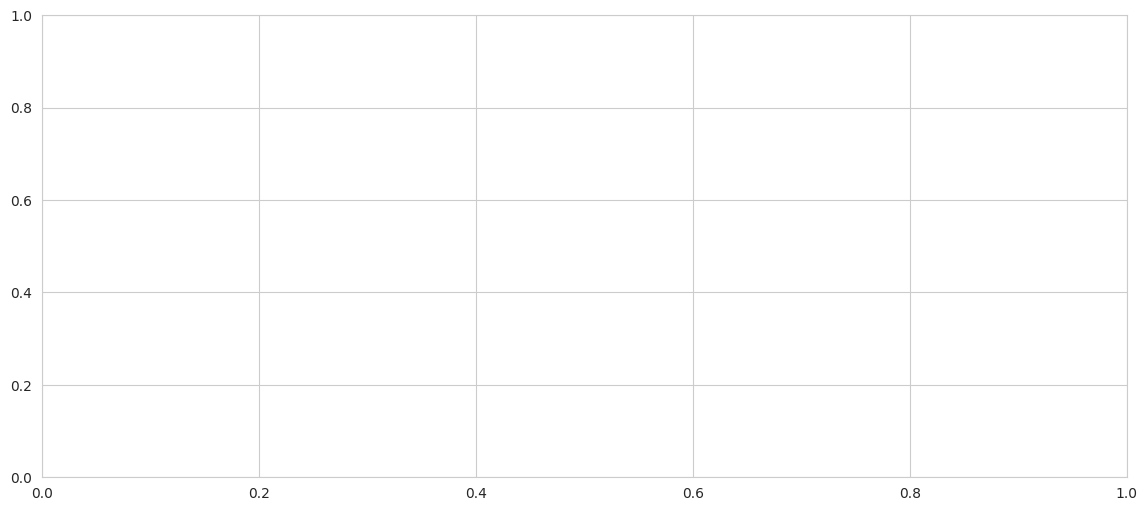

In [50]:
# Pick the most useful date column for visualization
# Priority: action_date > award_date > start_date > any other date
viz_col = None
priority_cols = ['action_date', 'award_date', 'start_date']

for pcol in priority_cols:
    if pcol in date_cols:
        viz_col = pcol
        break

if not viz_col and date_cols:
    viz_col = date_cols[0]

if viz_col:
    print(f"Visualizing: {viz_col}")
    
    # Parse dates
    df['_parsed_date'] = pd.to_datetime(df[viz_col].replace('', pd.NA), errors='coerce')
    
    # Plot distribution
    fig, ax = plt.subplots(figsize=(14, 6))
    
    valid_dates = df['_parsed_date'].dropna()
    if len(valid_dates) > 0:
        ax.hist(valid_dates, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
        ax.set_xlabel('Date')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of {viz_col}', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Clean up temp column
        df.drop('_parsed_date', axis=1, inplace=True)
    else:
        print("No valid dates to visualize")
else:
    print("No date columns available for visualization")

## Summary & Export

In [ ]:
# Export date column analysis
output_file = Path('../data/awards/date_columns_analysis.csv')
date_summary_df.to_csv(output_file, index=False)

print(f"=== SUMMARY ===")
print(f"Dataset type: {data_type.upper()}")
print(f"Total records: {len(df):,}")
print(f"Total columns: {df.shape[1]}")
print(f"Date columns found: {len(date_cols)}")
print(f"\nDate columns: {', '.join(date_cols)}")
print(f"\nAnalysis exported to: {output_file}")

## Dataset Preview

In [ ]:
# Show first few rows with date columns highlighted
if date_cols:
    print("Date columns + key identifiers:")
    
    # Build column list: identifiers + date columns
    id_cols = []
    if 'award_id' in df.columns:
        id_cols.append('award_id')
    if 'transaction_id' in df.columns:
        id_cols.append('transaction_id')
    if 'recipient_name' in df.columns:
        id_cols.append('recipient_name')
    
    display_cols = id_cols + date_cols
    print(df[display_cols].head(10))
else:
    print("Full dataset preview:")
    print(df.head())